In [1]:
from visual_transformer import VisionTransformerModel
from DIPutils import DIPTransform
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\parth\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set dataset path
dataset_path = r"C:\Users\parth\Downloads\Kindey-Stone-Dataset\Kindey-Stone-Dataset\Augmented"

In [3]:
# Define transformations (resize, normalize, etc.)
transform = transforms.Compose([
    # DIPTransform(target_size=500),  # Apply DIP pipeline
    # transforms.ToPILImage(),        # Convert back to PIL imagev
    transforms.Resize((224, 224)),  # Resize to model input size
    transforms.ToTensor(),          # Convert to tensor
])

In [4]:
# Load the dataset
dataset_path = dataset_path
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Define split sizes
total_size = len(dataset)
val_size = int(0.15 * total_size)  # 15% for validation
test_size = int(0.15 * total_size)  # 15% for testing
train_size = total_size - (val_size + test_size)  # Remaining 70% for training

# Split dataset
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
batch_size = 64 
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_ds)}, Validation size: {len(val_ds)}, Test size: {len(test_ds)}")
# also print the number of classes
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

Train size: 24821, Validation size: 5318, Test size: 5318
Number of classes: 2


In [5]:
# Define model
model = VisionTransformerModel(input_shape=(224, 224, 3), num_classes=2)
print(model)

VisionTransformerModel(
  (patch_embed): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (ffn): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=512, out_features=768, bias=True)
  )
  (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dense1): Linear(in_features=768, out_features=256, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (classifier): Linear(in_features=256, out_features=2, bias=True)
)


In [6]:
print(model.patch_embed.weight.shape)

torch.Size([768, 3, 16, 16])


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
def compute_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return (preds == labels).float().mean().item()


In [8]:
num_epochs = 20  # Set number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in train_loader:  # Assume train_loader is your DataLoader
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()
        correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct, val_total = 0, 0

    with torch.no_grad():  # No need to track gradients for validation
        for val_inputs, val_labels in val_loader:  # Assume val_loader is your validation DataLoader
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()

            val_correct += (torch.argmax(val_outputs, dim=1) == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}\n")

Using device: cuda
Epoch [1/20]
Train Loss: 0.6914, Train Accuracy: 0.5354
Val Loss: 0.6926, Val Accuracy: 0.5276

Epoch [2/20]
Train Loss: 0.6897, Train Accuracy: 0.5428
Val Loss: 0.6936, Val Accuracy: 0.5276

Epoch [3/20]
Train Loss: 0.6886, Train Accuracy: 0.5429
Val Loss: 0.6919, Val Accuracy: 0.5369

Epoch [4/20]
Train Loss: 0.6851, Train Accuracy: 0.5463
Val Loss: 0.6835, Val Accuracy: 0.5542

Epoch [5/20]
Train Loss: 0.6804, Train Accuracy: 0.5671
Val Loss: 0.6853, Val Accuracy: 0.5510

Epoch [6/20]
Train Loss: 0.6764, Train Accuracy: 0.5774
Val Loss: 0.6772, Val Accuracy: 0.5724

Epoch [7/20]
Train Loss: 0.6673, Train Accuracy: 0.5964
Val Loss: 0.6651, Val Accuracy: 0.5980

Epoch [8/20]
Train Loss: 0.6652, Train Accuracy: 0.5978
Val Loss: 0.6649, Val Accuracy: 0.6042

Epoch [9/20]
Train Loss: 0.6634, Train Accuracy: 0.5978
Val Loss: 0.6708, Val Accuracy: 0.5899

Epoch [10/20]
Train Loss: 0.6642, Train Accuracy: 0.5957
Val Loss: 0.6680, Val Accuracy: 0.5842

Epoch [11/20]
Train 

In [9]:
# save teh model
torch.save(model.state_dict(), 'model20ViT.pth')

In [10]:
# test teh model
model.eval()  # Set model to evaluation mode
correct, total = 0, 0
running_loss = 0.0
criterion = nn.CrossEntropyLoss()

with torch.no_grad():  # No need to track gradients for validation
    for test_inputs, test_labels in test_loader:  # Assume val_loader is your validation DataLoader
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        loss = criterion(test_outputs, test_labels)
        running_loss += loss.item()

        correct += (torch.argmax(test_outputs, dim=1) == test_labels).sum().item()
        total += test_labels.size(0)
test_loss = running_loss / len(test_loader)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.6427, Test Accuracy: 0.6286


In [11]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate model on test data and return metrics
    Args:
        model: PyTorch model
        test_loader: DataLoader with test data
        device: 'cuda' or 'cpu'
    Returns:
        Dictionary containing metrics and confusion matrix
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    recall = recall_score(all_labels, all_preds, average='binary')  # for 2 classes
    f1 = f1_score(all_labels, all_preds, average='binary')
    cm = confusion_matrix(all_labels, all_preds)
    
    return {
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

def plot_confusion_matrix(cm):
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [12]:
metrics = evaluate_model(model, test_loader, device)

print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")
print("Confusion Matrix:")
print(metrics['confusion_matrix'])

Recall: 0.4195
F1 Score: 0.5031
Confusion Matrix:
[[2343  591]
 [1384 1000]]


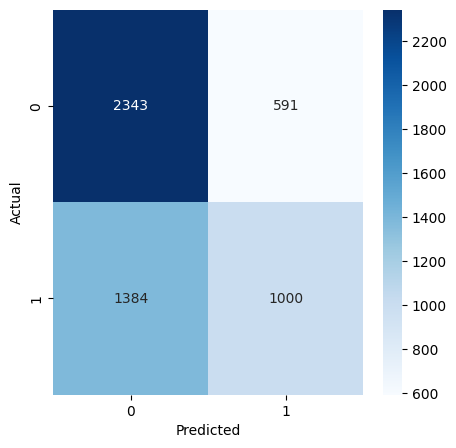

In [13]:
plot_confusion_matrix(metrics['confusion_matrix'])